In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalgraphicalmodels import CausalGraphicalModel, StructuralCausalModel
import pylogit
from collections import OrderedDict
import pylogit as cm
from functools import reduce
import statsmodels.api as sm
import statsmodels.formula.api as smf
from math import ceil

from IPython import display
import seaborn as sns

import numpy as np
import numpy.random as npr
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import statsmodels.api as sm

from tensorflow_probability import edward2 as ed
from sklearn.datasets import load_breast_cancer
from pandas.plotting import scatter_matrix
from scipy import sparse, stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

import matplotlib
matplotlib.rcParams.update({'font.sans-serif' : 'Helvetica',
                            'axes.labelsize': 10,
                            'xtick.labelsize' : 6,
                            'ytick.labelsize' : 6,
                            'axes.titlesize' : 10})
import matplotlib.pyplot as plt

import seaborn as sns
color_names = ["windows blue",
               "amber",
               "crimson",
               "faded green",
               "dusty purple",
               "greyish"]
colors = sns.xkcd_palette(color_names)
sns.set(style="white", palette=sns.xkcd_palette(color_names), color_codes = False)

from factor_models import *

import os
os.listdir('.')

['investigating_deconfounder.py',
 'investigating_deconfounder.ipynb',
 'Untitled.ipynb',
 '.gitkeep',
 '__pycache__',
 'factor_models.py',
 '.ipynb_checkpoints']

In [7]:
PATH = '../../data/raw/nmesdata.csv'

In [8]:
data = pd.read_csv(PATH)
data.head()

,PIDX,LASTAGE,MALE,RACE3,eversmk,current,former,smoke,AGESMOKE,CIGSSMOK,...,TOTALSP3,lc5,chd5,beltuse,educate,marital,SREGION,POVSTALB,flag,age
0,20843014,80,0,3,0.0,NaN,0.0,0.0,NaN,NaN,...,20.0,0,1,3.0,4,2.0,1,1.0,0,1
1,20836012,29,0,3,1.0,1.0,0.0,1.0,15.0,20.0,...,0.0,0,0,3.0,3,1.0,1,3.0,0,0
2,20836025,28,1,3,1.0,1.0,0.0,1.0,16.0,18.0,...,0.0,0,0,2.0,3,1.0,1,3.0,0,0
3,20835019,29,0,3,1.0,1.0,0.0,1.0,17.0,NaN,...,0.0,0,0,2.0,1,5.0,1,4.0,2,0
4,20835022,28,0,3,1.0,NaN,NaN,NaN,20.0,NaN,...,0.0,0,0,3.0,1,5.0,1,1.0,2,0


## Outcome model definition

In [18]:
columns = ['TOTALEXP', 'marital', 'LASTAGE']

In [52]:
df = data[columns]
df = df.dropna()

df = (df - df.mean())/df.std()

In [53]:
beta_exp = np.random.normal(loc=0, scale = 1, size = df.shape[0])
beta_mar = np.random.normal(loc=0, scale = 1, size = df.shape[0])
beta_age = np.random.normal(loc=0, scale = 1, size = df.shape[0])
eps = np.random.normal(loc=0, scale = 1, size = df.shape[0])

In [54]:
df.head()

,TOTALEXP,marital,LASTAGE
0,-0.263769,-0.079593,1.784915
1,-0.265997,-0.714245,-0.928033
2,-0.283402,-0.714245,-0.981228
3,-0.190480,1.824362,-0.928033
4,-0.312021,1.824362,-0.981228


In [55]:
df['y'] = beta_exp*df['TOTALEXP'] + beta_mar*df['marital'] + beta_age*df['LASTAGE'] + eps

In [56]:
mod = smf.ols('y ~ -1 + TOTALEXP + marital + LASTAGE', data = df)
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              12.04
Date:                Fri, 24 Apr 2020   Prob (F-statistic):                    7.20e-08
Time:                        19:59:45   Log-Likelihood:                         -50436.
No. Observations:               23961   AIC:                                  1.009e+05
Df Residuals:                   23958   BIC:                                  1.009e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
TOTALEXP       0.0776      0.013      5.930      0.000       0.052       0.103
marital        0.0110      0.014      0.801      0.423      -0.016       0.038
LASTAGE       -0.0117      0.014     -0.837      0.403      -0.039       0.016
==============================================================================
Omnibus:                     4399.230   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           119148.127
Skew:                          -0.075   Prob(JB):                         0.00
Kurtosis:                      13.923   Cond. No.                         1.52
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Factor model

Inferred axes:
[[0.56870633 1.4627289 ]]
Standard Deviation:
[[0.00829643 0.01024641]]


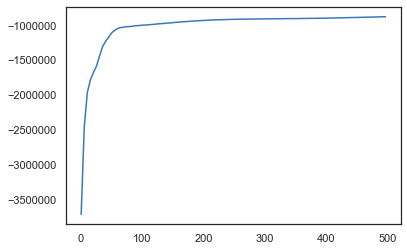

1

P-value, average:  [0.3332111714899532]


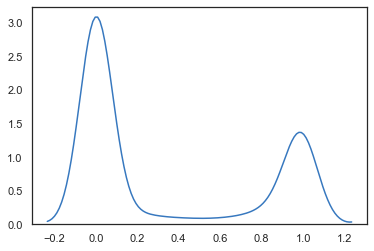

In [64]:
latent_dim = 1
X = df[['marital', 'TOTALEXP']]

confounders, holdouts, holdoutmasks, holdoutrow= confounder_ppca(holdout_portion=0.2, X=X, 
                                                                 latent_dim=latent_dim, linear = True)

holdouts_req = [holdouts]
display.display(len(holdouts_req))

confounder_req = [confounders]

n_rep = 100 # number of replicated datasets we generate
holdout_gen_util = []

for j in range(len(holdouts_req)):
    holdout_gen = np.zeros((n_rep,*(holdouts_req[j].shape)))
    
    for i in range(n_rep):
        w_sample = npr.normal(confounder_req[j][0], confounder_req[j][1])
        z_sample = npr.normal(confounder_req[j][2], confounder_req[j][3])
        
        data_dim_temp = holdouts_req[j].shape[1]
        latent_dim_temp = confounder_req[j][2].shape[1]
        num_datapoints_temp = holdouts_req[j].shape[0]
        
        with ed.interception(replace_latents(w_sample, z_sample)):
            generate = ppca_model(
                data_dim=data_dim_temp, latent_dim=latent_dim_temp,
                num_datapoints=num_datapoints_temp, 
                stddv_datapoints=0.1, holdout_mask=holdoutmasks, linear = False)

        with tf.Session() as sess:
            x_generated, _ = sess.run(generate)

        # look only at the heldout entries
        holdout_gen[i] = np.multiply(x_generated, holdoutmasks)
        
    holdout_gen_util.append(holdout_gen)
    
    
n_eval = 100 # we draw samples from the inferred Z and W
obs_ll_per_zi_per_mode = []
rep_ll_per_zi_per_mode = []
stddv_datapoints=0.1
for mode in range(len(holdouts_req)):
    obs_ll = []
    rep_ll = []

    for j in range(n_eval):
        w_sample = npr.normal(confounder_req[mode][0], confounder_req[mode][1])
        z_sample = npr.normal(confounder_req[mode][2], confounder_req[mode][3])

        holdoutmean_sample = np.multiply(z_sample.dot(w_sample), holdoutmasks)
        obs_ll.append(np.mean(stats.norm(holdoutmean_sample, \
                            stddv_datapoints).logpdf(holdouts_req[mode]), axis=1))

        rep_ll.append(np.mean(stats.norm(holdoutmean_sample, \
                            stddv_datapoints).logpdf(holdout_gen_util[mode]),axis=2))

    obs_ll_per_zi, rep_ll_per_zi = np.mean(np.array(obs_ll), axis=0), np.mean(np.array(rep_ll), axis=0)
    obs_ll_per_zi_per_mode.append(obs_ll_per_zi)
    rep_ll_per_zi_per_mode.append(rep_ll_per_zi)

    
pval_mode = []
for mode in range(len(holdouts_req)):
    pvals = np.array([np.mean(rep_ll_per_zi_per_mode[mode][:,i] < obs_ll_per_zi_per_mode[mode][i]) 
                      for i in range(holdouts_req[mode].shape[0])])
    holdout_subjects = np.unique(holdoutrow)
    overall_pval = np.mean(pvals[holdout_subjects])
    pval_mode.append(overall_pval)
#     print("Predictive check p-values", overall_pval)

print("P-value, average: ", pval_mode)

display.display(sns.kdeplot(pvals[holdout_subjects]))

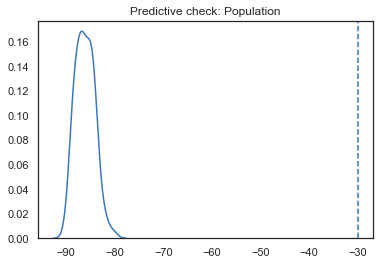

In [65]:
overall_ll_est = rep_ll_per_zi.mean(axis=1)

overall_ll_obs = obs_ll_per_zi.mean()

sns.kdeplot(overall_ll_est).set_title("Predictive check: Population")
plt.axvline(x=overall_ll_obs, linestyle='--')

In [66]:
df['confounder_PPCA'] = confounders[2]

## Re-run regression

In [61]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              12.04
Date:                Fri, 24 Apr 2020   Prob (F-statistic):                    7.20e-08
Time:                        20:03:36   Log-Likelihood:                         -50436.
No. Observations:               23961   AIC:                                  1.009e+05
Df Residuals:                   23958   BIC:                                  1.009e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
TOTALEXP       0.0776      0.013      5.930      0.000       0.052       0.103
marital        0.0110      0.014      0.801      0.423      -0.016       0.038
LASTAGE       -0.0117      0.014     -0.837      0.403      -0.039       0.016
==============================================================================
Omnibus:                     4399.230   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           119148.127
Skew:                          -0.075   Prob(JB):                         0.00
Kurtosis:                      13.923   Cond. No.                         1.52
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
mod_no = smf.ols('y ~ -1 + TOTALEXP + marital ', data = df)
results_no = mod_no.fit()
results_no.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              17.70
Date:                Fri, 24 Apr 2020   Prob (F-statistic):                    2.07e-08
Time:                        20:03:39   Log-Likelihood:                         -50436.
No. Observations:               23961   AIC:                                  1.009e+05
Df Residuals:                   23959   BIC:                                  1.009e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
TOTALEXP       0.0755      0.013      5.878      0.000       0.050       0.101
marital        0.0150      0.013      1.171      0.242      -0.010       0.040
==============================================================================
Omnibus:                     4400.133   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           119315.015
Skew:                          -0.074   Prob(JB):                         0.00
Kurtosis:                      13.931   Cond. No.                         1.04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
mod_after = smf.ols('y ~ -1 + TOTALEXP + marital + confounder_PPCA', data = df)
results_after = mod_after.fit()
results_after.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              13.05
Date:                Fri, 24 Apr 2020   Prob (F-statistic):                    1.63e-08
Time:                        20:04:32   Log-Likelihood:                         -50435.
No. Observations:               23961   AIC:                                  1.009e+05
Df Residuals:                   23958   BIC:                                  1.009e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
TOTALEXP            0.0894      0.015      6.074      0.000       0.061       0.118
marital             0.0355      0.017      2.135      0.033       0.003       0.068
confounder_PPCA    -0.0388      0.020     -1.935      0.053      -0.078       0.000
==============================================================================
Omnibus:                     4395.468   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           118270.792
Skew:                          -0.083   Prob(JB):                         0.00
Kurtosis:                      13.883   Cond. No.                         2.39
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
mod_after = smf.ols('y ~ -1 + TOTALEXP + marital + confounder_PPCA', data = df)
results_after = mod_after.fit()
results_after.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              12.49
Date:                Fri, 24 Apr 2020   Prob (F-statistic):                    3.71e-08
Time:                        20:09:19   Log-Likelihood:                         -50435.
No. Observations:               23961   AIC:                                  1.009e+05
Df Residuals:                   23958   BIC:                                  1.009e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
TOTALEXP            0.0573      0.018      3.181      0.001       0.022       0.093
marital             0.0020      0.016      0.125      0.900      -0.029       0.033
confounder_PPCA     0.0335      0.023      1.435      0.151      -0.012       0.079
==============================================================================
Omnibus:                     4397.244   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           118852.216
Skew:                          -0.077   Prob(JB):                         0.00
Kurtosis:                      13.910   Cond. No.                         2.78
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Functions

In [34]:
def confounder_ppca(X, latent_dim, holdout_portion, linear = True):
    # randomly holdout some entries of X
    num_datapoints, data_dim = X.shape

    holdout_portion = holdout_portion
    n_holdout = int(holdout_portion * num_datapoints * data_dim)

    holdout_row = np.random.randint(num_datapoints, size=n_holdout)
    holdout_col = np.random.randint(data_dim, size=n_holdout)
    holdout_mask = (sparse.coo_matrix((np.ones(n_holdout), \
                                (holdout_row, holdout_col)), \
                                shape = X.shape)).toarray()

    holdout_subjects = np.unique(holdout_row)

    x_train = np.multiply(1-holdout_mask, X)
    x_vad = np.multiply(holdout_mask, X)

    def ppca_model(data_dim, latent_dim, num_datapoints, stddv_datapoints, linear = linear):
        w = ed.Normal(loc=tf.zeros([latent_dim, data_dim]),
                    scale=tf.ones([latent_dim, data_dim]),
                    name="w")  # parameter
        z = ed.Normal(loc=tf.zeros([num_datapoints, latent_dim]),
                    scale=tf.ones([num_datapoints, latent_dim]), 
                    name="z")  # local latent variable / substitute confounder
        ## linear or quadratic factor model?
        if linear:
            x = ed.Normal(loc=tf.multiply(tf.matmul(z, w), 1-holdout_mask),
                    scale=stddv_datapoints * tf.ones([num_datapoints, data_dim]),
                    name="x")  # (modeled) data
        else: 
            x = ed.Normal(loc=tf.multiply(tf.matmul(z, w), 1-holdout_mask) 
                          + tf.multiply(tf.matmul(z**2, w**2), 1-holdout_mask),
                    scale=stddv_datapoints * tf.ones([num_datapoints, data_dim]),
                    name="x")
            
            
        return x, (w, z)

    log_joint = ed.make_log_joint_fn(ppca_model)

    latent_dim = latent_dim
    stddv_datapoints = 0.1

    model = ppca_model(data_dim=data_dim,
                       latent_dim=latent_dim,
                       num_datapoints=num_datapoints,
                       stddv_datapoints=stddv_datapoints,
                      linear = linear)

    def variational_model(qw_mean, qw_stddv, qz_mean, qz_stddv):
        qw = ed.Normal(loc=qw_mean, scale=qw_stddv, name="qw")
        qz = ed.Normal(loc=qz_mean, scale=qz_stddv, name="qz")
        return qw, qz


    log_q = ed.make_log_joint_fn(variational_model)

    def target(w, z):
        """Unnormalized target density as a function of the parameters."""
        return log_joint(data_dim=data_dim,
                       latent_dim=latent_dim,
                       num_datapoints=num_datapoints,
                       stddv_datapoints=stddv_datapoints,
                       w=w, z=z, x=x_train)

    def target_q(qw, qz):
        return log_q(qw_mean=qw_mean, qw_stddv=qw_stddv,
                   qz_mean=qz_mean, qz_stddv=qz_stddv,
                   qw=qw, qz=qz)


    qw_mean = tf.Variable(np.ones([latent_dim, data_dim]), dtype=tf.float32)
    qz_mean = tf.Variable(np.ones([num_datapoints, latent_dim]), dtype=tf.float32)
    qw_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([latent_dim, data_dim]), dtype=tf.float32))
    qz_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([num_datapoints, latent_dim]), dtype=tf.float32))

    qw, qz = variational_model(qw_mean=qw_mean, qw_stddv=qw_stddv,
                               qz_mean=qz_mean, qz_stddv=qz_stddv)


    energy = target(qw, qz)
    entropy = -target_q(qw, qz)

    elbo = energy + entropy


    optimizer = tf.train.AdamOptimizer(learning_rate = 0.05)
    train = optimizer.minimize(-elbo)

    init = tf.global_variables_initializer()

    t = []

    num_epochs = 500

    with tf.Session() as sess:
        sess.run(init)

        for i in range(num_epochs):
            sess.run(train)
            if i % 5 == 0:
                t.append(sess.run([elbo]))

            w_mean_inferred = sess.run(qw_mean)
            w_stddv_inferred = sess.run(qw_stddv)
            z_mean_inferred = sess.run(qz_mean)
            z_stddv_inferred = sess.run(qz_stddv)

    print("Inferred axes:")
    print(w_mean_inferred)
    print("Standard Deviation:")
    print(w_stddv_inferred)

    plt.plot(range(1, num_epochs, 5), t)
    plt.show()

    def replace_latents(w, z):

        def interceptor(rv_constructor, *rv_args, **rv_kwargs):
            """Replaces the priors with actual values to generate samples from."""
            name = rv_kwargs.pop("name")
            if name == "w":
                rv_kwargs["value"] = w
            elif name == "z":
                rv_kwargs["value"] = z
            return rv_constructor(*rv_args, **rv_kwargs)

        return interceptor
    
    return [w_mean_inferred, w_stddv_inferred, z_mean_inferred, z_stddv_inferred], x_vad, holdout_mask, holdout_row

In [35]:
def ppca_model(data_dim, latent_dim, num_datapoints, stddv_datapoints, holdout_mask, linear = True):
    w = ed.Normal(loc=tf.zeros([latent_dim, data_dim]),
                scale=tf.ones([latent_dim, data_dim]),
                name="w")  # parameter
    z = ed.Normal(loc=tf.zeros([num_datapoints, latent_dim]),
                scale=tf.ones([num_datapoints, latent_dim]), 
                name="z")  # local latent variable / substitute confounder
    if linear:
        x = ed.Normal(loc=tf.multiply(tf.matmul(z, w), 1-holdout_mask),
                scale=stddv_datapoints * tf.ones([num_datapoints, data_dim]),
                name="x")  # (modeled) data
    else: 
        x = ed.Normal(loc=tf.multiply(tf.matmul(z, w), 1-holdout_mask) 
                      + tf.multiply(tf.matmul(z**2, w**2), 1-holdout_mask),
                scale=stddv_datapoints * tf.ones([num_datapoints, data_dim]),
                name="x")


    return x, (w, z)




def replace_latents(w, z):

    def interceptor(rv_constructor, *rv_args, **rv_kwargs):
        """Replaces the priors with actual values to generate samples from."""
        name = rv_kwargs.pop("name")
        if name == "w":
            rv_kwargs["value"] = w
        elif name == "z":
            rv_kwargs["value"] = z
        return rv_constructor(*rv_args, **rv_kwargs)

    return interceptor